In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from tensorflow.keras.utils import to_categorical
# Deep Learning
#import tensorflow as tf

In [2]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [3]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [4]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [5]:
add_data_info()

In [6]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [7]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [8]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

df['rally_tratada'] = (df['rallyCount']/2).apply(np.floor)

### Adição da coluna how_ended

In [9]:
# df['end']
df['how_ended'] = df.loc[:, '2nd'].str[-1]
df['how_ended'].fillna(df.loc[:, '1st'].str[-1], inplace=True)

df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,3.0,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,0.0,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,0.0,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,0.0,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,6.0,#


In [10]:
# vamos entender melhor isso aqui

df['how_ended'].value_counts()

how_ended
#    6264
*    6054
@    5820
d     267
n     249
w      66
x      14
C      13
;       4
Name: count, dtype: int64

In [11]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

In [12]:
# # Data set final sendo "I win" = 1 e "i serve = 1"
# df = df[(df['i_win'] == 1) & (df['i_serve'] == 1)]
# df

In [13]:
# Data set final sendo "i serve = 1"
df = df[df['i_serve'] == 1]
df

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended,serve_return
5,642,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,6,0,0,1,0,0-0,2 (1),1,0,NaN,2,1,CR,4n,6b37b2f3s2f1f1f3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,7,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,6,b37 b2 f3 s2 f1 f1 f3,3.0,@,b37
6,643,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,7,0,0,1,0,15-0,2 (2),1,0,NaN,2,1,CR,4n,5b38s3b3b3b3b3b1*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,8,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,b38 s3 b3 b3 b3 b3 b1,4.0,*,b38
7,644,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,8,0,0,1,0,15-15,2 (3),1,0,NaN,2,1,CR,6n,5f28f3s2f+3b2v1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,f28 f3 s2 f3 b2 v1,3.0,@,f28
8,645,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,9,0,0,1,0,15-30,2 (4),1,0,NaN,2,1,CR,4d,6f38f3b2f1f2f3d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,6,f38 f3 b2 f1 f2 f3,3.0,@,f38
9,646,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,10,0,0,1,0,15-40,2 (5),1,0,NaN,2,1,CR,6d,5b3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,5,b3,0.0,@,b3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19313,295474,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,184,1,1,5,3,0-0,30,1,0,NaN,2,1,AM,6d,5b29f3b2f1r2f3s2f1f2d#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,9,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,5,b29 f3 b2 f1 r2 f3 s2 f1 f2,4.0,#,b29
19314,295475,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,185,1,1,5,3,15-0,30,1,0,NaN,2,1,AM,4d,4s3n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,1,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,4,s3,0.0,#,s3
19315,295476,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,186,1,1,5,3,30-0,30,1,0,NaN,2,1,AM,6n,6b37b3b1f1f3b2f3b3b1r1u+3b-3z1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,13,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,6,b37 b3 b1 f1 f3 b2 f3 b3 b1 r1 u3 b3 z1,6.0,@,b37
19316,295477,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,187,1,1,5,3,40-0,30,1,0,NaN,2,1,AM,4n,5b18*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,2,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,0,1,5,b18,1.0,*,b18


In [14]:
df

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended,serve_return
5,642,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,6,0,0,1,0,0-0,2 (1),1,0,NaN,2,1,CR,4n,6b37b2f3s2f1f1f3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,7,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,6,b37 b2 f3 s2 f1 f1 f3,3.0,@,b37
6,643,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,7,0,0,1,0,15-0,2 (2),1,0,NaN,2,1,CR,4n,5b38s3b3b3b3b3b1*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,8,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,b38 s3 b3 b3 b3 b3 b1,4.0,*,b38
7,644,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,8,0,0,1,0,15-15,2 (3),1,0,NaN,2,1,CR,6n,5f28f3s2f+3b2v1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,f28 f3 s2 f3 b2 v1,3.0,@,f28
8,645,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,9,0,0,1,0,15-30,2 (4),1,0,NaN,2,1,CR,4d,6f38f3b2f1f2f3d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,6,f38 f3 b2 f1 f2 f3,3.0,@,f38
9,646,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,10,0,0,1,0,15-40,2 (5),1,0,NaN,2,1,CR,6d,5b3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,5,b3,0.0,@,b3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19313,295474,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,184,1,1,5,3,0-0,30,1,0,NaN,2,1,AM,6d,5b29f3b2f1r2f3s2f1f2d#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,9,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,5,b29 f3 b2 f1 r2 f3 s2 f1 f2,4.0,#,b29
19314,295475,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,185,1,1,5,3,15-0,30,1,0,NaN,2,1,AM,4d,4s3n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,1,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,4,s3,0.0,#,s3
19315,295476,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,186,1,1,5,3,30-0,30,1,0,NaN,2,1,AM,6n,6b37b3b1f1f3b2f3b3b1r1u+3b-3z1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,13,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,6,b37 b3 b1 f1 f3 b2 f3 b3 b1 r1 u3 b3 z1,6.0,@,b37
19316,295477,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,187,1,1,5,3,40-0,30,1,0,NaN,2,1,AM,4n,5b18*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,2,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,0,1,5,b18,1.0,*,b18


In [15]:
combine_lambda = lambda x: '{}{}'.format(str(x.i_win), str(x.dir_srv))
df['i_win_dir_srv'] = df.apply(combine_lambda, axis = 1)

In [16]:
df['i_win_dir_srv'].unique()

array(['16', '05', '06', '15', '14', '04'], dtype=object)

In [17]:
df

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended,serve_return,i_win_dir_srv
5,642,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,6,0,0,1,0,0-0,2 (1),1,0,NaN,2,1,CR,4n,6b37b2f3s2f1f1f3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,7,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,6,b37 b2 f3 s2 f1 f1 f3,3.0,@,b37,16
6,643,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,7,0,0,1,0,15-0,2 (2),1,0,NaN,2,1,CR,4n,5b38s3b3b3b3b3b1*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,8,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,b38 s3 b3 b3 b3 b3 b1,4.0,*,b38,05
7,644,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,8,0,0,1,0,15-15,2 (3),1,0,NaN,2,1,CR,6n,5f28f3s2f+3b2v1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,f28 f3 s2 f3 b2 v1,3.0,@,f28,05
8,645,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,9,0,0,1,0,15-30,2 (4),1,0,NaN,2,1,CR,4d,6f38f3b2f1f2f3d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,6,f38 f3 b2 f1 f2 f3,3.0,@,f38,06
9,646,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,10,0,0,1,0,15-40,2 (5),1,0,NaN,2,1,CR,6d,5b3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,5,b3,0.0,@,b3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19313,295474,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,184,1,1,5,3,0-0,30,1,0,NaN,2,1,AM,6d,5b29f3b2f1r2f3s2f1f2d#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,9,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,5,b29 f3 b2 f1 r2 f3 s2 f1 f2,4.0,#,b29,15
19314,295475,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,185,1,1,5,3,15-0,30,1,0,NaN,2,1,AM,4d,4s3n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,2,1,1,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,4,s3,0.0,#,s3,14
19315,295476,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,186,1,1,5,3,30-0,30,1,0,NaN,2,1,AM,6n,6b37b3b1f1f3b2f3b3b1r1u+3b-3z1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,13,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,1,1,6,b37 b3 b1 f1 f3 b2 f3 b3 b1 r1 u3 b3 z1,6.0,@,b37,16
19316,295477,20170107-M-Doha-F-Novak_Djokovic-Andy_Murray,187,1,1,5,3,40-0,30,1,0,NaN,2,1,AM,4n,5b18*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,2,20170107,Doha,F,Hard,Novak Djokovic,Andy Murray,0,1,0,1,5,b18,1.0,*,b18,05


## Dataset finalizado ##

In [18]:
df['serve_return'].nunique()

72

In [19]:
df['how_ended'].nunique()

9

In [20]:
#df = df[df['serve_return']!=""]

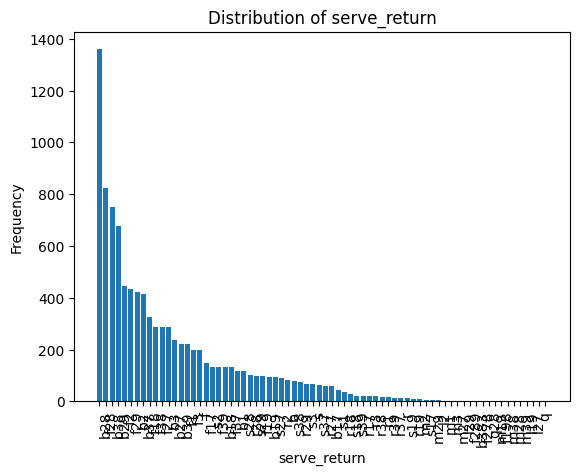

In [21]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts()

plt.bar(value_counts.index, value_counts.values )
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [22]:
serve_return_counts = df["serve_return"].value_counts().reset_index()
serve_return_counts.columns = ["serve_return", "frequency"]
serve_return_counts = serve_return_counts.sort_values("frequency", ascending=False )

serve_return_counts.head(10)


,serve_return,frequency
0,,1359
1,b28,823
2,f28,749
3,b38,678
4,b29,446
5,f2,434
6,f29,421
7,b2,414
8,b37,328
9,f18,289


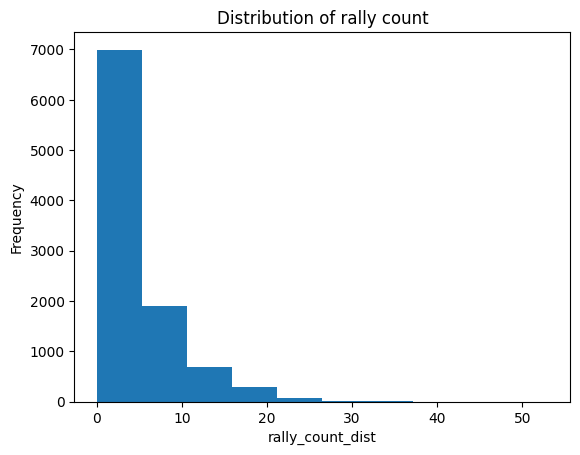

In [23]:
rally_count_dist = df["rallyCount"]
rally_count_dist = rally_count_dist.dropna()

plt.hist(rally_count_dist)
plt.xlabel("rally_count_dist")
plt.ylabel("Frequency")
plt.title("Distribution of rally count")
plt.show()

In [24]:
rally_counts = df["rallyCount"].value_counts().reset_index()
rally_counts.columns = ["rally_counts", "frequency"]
rally_counts = rally_counts.sort_values("frequency", ascending=False )

print(rally_counts)

    rally_counts  frequency
0              1       2671
1              3       1340
2              2       1070
3              5        784
4              4        773
5              6        579
6              7        444
7              8        382
8              0        358
9              9        269
10            10        234
11            12        181
12            11        177
13            13        126
14            14        120
15            16         87
16            15         76
17            17         57
18            18         51
19            19         40
20            20         32
21            22         25
22            21         21
23            23         16
24            25         15
25            24         12
26            28          5
27            26          5
29            30          4
28            27          4
30            29          3
31            31          3
32            34          2
33            32          2
34            35    

## Geração das features

In [25]:
features = ['Surface',
            'Round',
            'Grand Slam',
            #'i_serve',
            'is_second_service',
            #'dir_srv',
            #'rallyCount',
            'rally_tratada',
            'isUnforced',
            'isForced',
            "serve_return",
            "how_ended"
            ]
X = df[features]

y = df[['i_win_dir_srv']]

In [26]:
y = y.astype('int64')

In [27]:
y['i_win_dir_srv'] = y['i_win_dir_srv'].map({14:0, 15:1, 16:2, 4:3, 5:4, 6:5})

In [28]:
y = to_categorical(y, num_classes = 6)
y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [29]:
y[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [30]:
feat_categorical = ['Surface','Round','dir_srv','serve_return','how_ended']

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 5 to 19317
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Surface            9973 non-null   object 
 1   Round              9973 non-null   object 
 2   Grand Slam         9973 non-null   int64  
 3   is_second_service  9973 non-null   int64  
 4   rally_tratada      9973 non-null   float64
 5   isUnforced         9973 non-null   int64  
 6   isForced           9973 non-null   int64  
 7   serve_return       9973 non-null   object 
 8   how_ended          9973 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 779.1+ KB


## separação - treino, teste e validação

In [32]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

# Train-Val Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4)


In [33]:
# ## Separating features and target in the Train, Val and Test Set

# X_train = train[features]
# y_train = train['dir_srv']

# X_val = val[features]
# y_val = val['dir_srv']

# X_test = test[features]
# y_test = test['dir_srv']

In [34]:
# print(len(train), 'train examples')
# print(len(val), 'validation examples')
# print(len(test), 'test examples')

In [35]:
X_train['serve_return'].nunique()

60

## Inicio do modelo - pre processamento e encoder

In [36]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [37]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28ec04ac0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28ec057e0>)])

In [38]:
preproc.fit_transform(X_train).shape

(3589, 86)

In [39]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [40]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

# 2. Compiling
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [42]:
# 3. Training
es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 10,
                   verbose = 0,
                   restore_best_weights = True)

history = model.fit(X_train_preproc,
                   y_train,
                   validation_data = (X_val_preproc, y_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

Epoch 1/500
57/57 [==============================] - 0s 2ms/step - loss: 1.7741 - accuracy: 0.2243 - val_loss: 1.7265 - val_accuracy: 0.2527
Epoch 2/500
57/57 [==============================] - 0s 1ms/step - loss: 1.7206 - accuracy: 0.2563 - val_loss: 1.6732 - val_accuracy: 0.2510
Epoch 3/500
57/57 [==============================] - 0s 1ms/step - loss: 1.6683 - accuracy: 0.2633 - val_loss: 1.6155 - val_accuracy: 0.2611
Epoch 4/500
57/57 [==============================] - 0s 1ms/step - loss: 1.6329 - accuracy: 0.2739 - val_loss: 1.5720 - val_accuracy: 0.2749
Epoch 5/500
57/57 [==============================] - 0s 1ms/step - loss: 1.6038 - accuracy: 0.2636 - val_loss: 1.5473 - val_accuracy: 0.2744
Epoch 6/500
57/57 [==============================] - 0s 1ms/step - loss: 1.5860 - accuracy: 0.2825 - val_loss: 1.5276 - val_accuracy: 0.3041
Epoch 7/500
57/57 [==============================] - 0s 1ms/step - loss: 1.5590 - accuracy: 0.2962 - val_loss: 1.5103 - val_accuracy: 0.3020
Epoch 8/500
5

## Resultado final / evaluate

In [43]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

125/125 [==============================] - 0s 531us/step - loss: 1.4111 - accuracy: 0.3634
accuracy = 0.363


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2784      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                288       
                                                                 
 dropout_2 (Dropout)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1

In [45]:
X_test_preproc[:1,:]

array([[-1.00027867,  1.31029812, -0.44532405, -0.67789114, -0.67395396,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [46]:
model.predict(X_test_preproc[:1,:])

1/1 [==============================] - 0s 160ms/step


array([[0.3242714 , 0.2365625 , 0.27695897, 0.06221114, 0.04757703,
        0.05241894]], dtype=float32)

In [47]:
type(X_test_preproc)

numpy.ndarray

## Verificação loss/accuracy - overfit / underfit

In [48]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

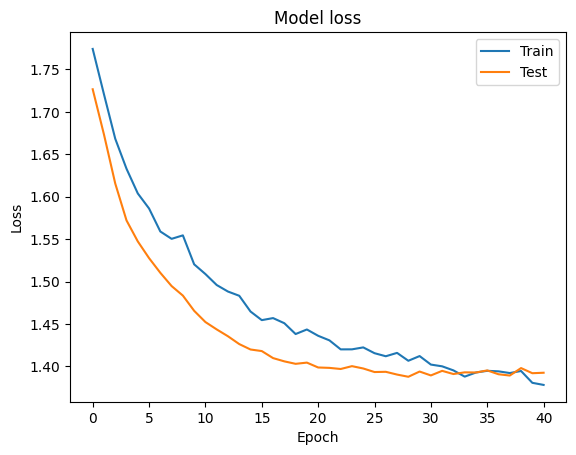

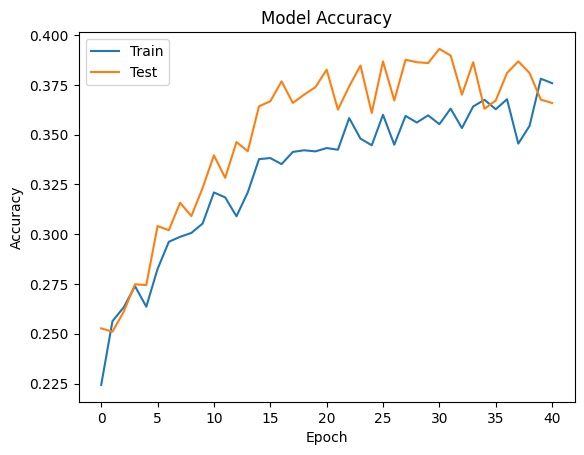

In [49]:
plot_loss_accuracy(history)